
Numerical Results:

CHANNEL DATASET:
Scale:     [2, 4, 6, 8]
FNO:       [0.031755429819226265, 0.17232777839899063, 0.3243549674749374, 0.42592110204696654]
UNet:      [0.022307000540196895, 0.15307339876890183, 0.2927600985765457, 0.4195220527648926]
Diffusion: [0.02269139328598976, 0.1487925819158554, 0.26952616012096403, 0.37449131393432616]

CYLINDER DATASET:
Scale:     [2, 4, 6, 8]
FNO:       [0.0011785113334005315, 0.0014934742431496344, 0.0015274876218643926, 0.0017487712958384129]
UNet:      [0.0006266730451320727, 0.0007016107519452889, 0.001341817242699483, 0.001392501755617559]
Diffusion: [0.0009529311496335718, 0.0010389636089611384, 0.001516066048116911, 0.0018186492250404423]

KM DATASET:
Scale:     [2, 4, 6, 8]
FNO:       [0.03726250884355977, 0.0916189145995304, 0.16760100219398738, 0.2343353247269988]
UNet:      [0.0023991712339920925, 0.01702905030688271, 0.06510118966689334, 0.1264056649059057]
Diffusion: [0.0023801258328603582, 0.017090953947626986, 0.0628549751359

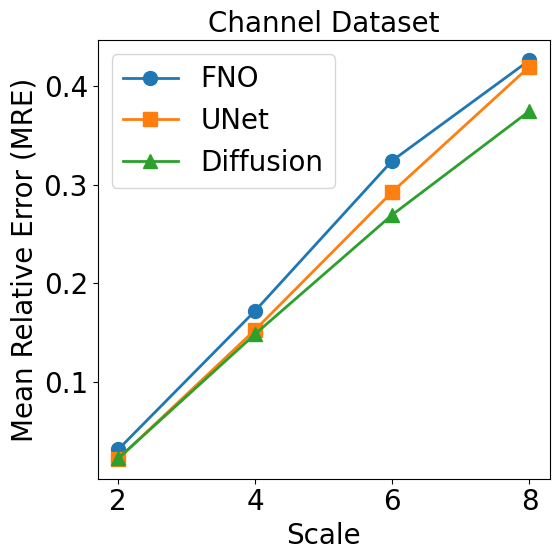

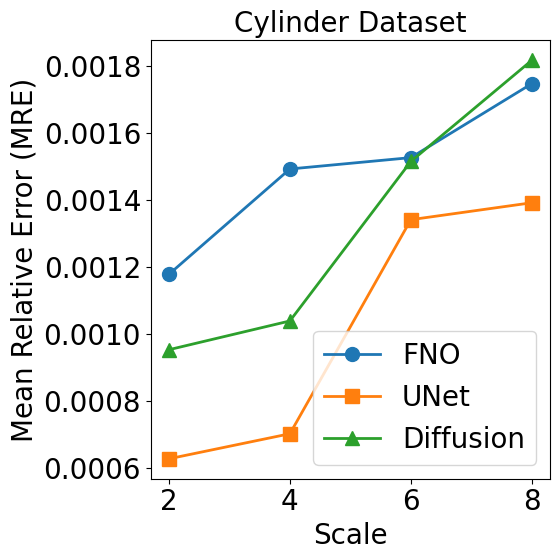

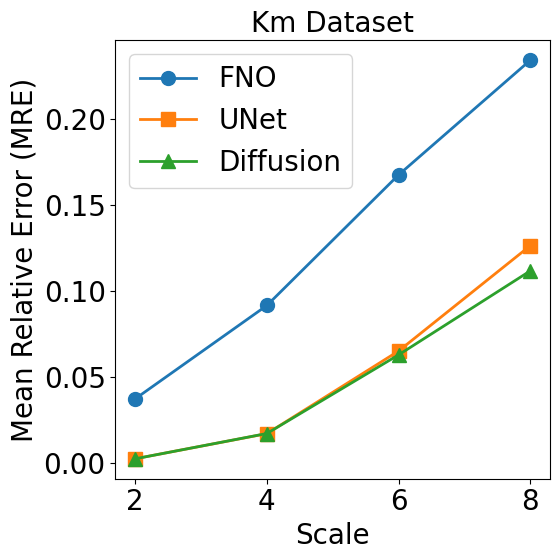

In [11]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt

def extract_mre_from_log(file_path):
    """
    Extract the final MRE (Mean Relative Error) value from a training log file.
    
    Args:
        file_path (str): Path to the log file
        
    Returns:
        float: The final MRE value
    """
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    # Look for validation lines which contain either MRE pattern
    validation_lines = [line for line in lines if ('Avg Test MRE Validation Loss' in line) or ('Avg MRE test Loss' in line)]
    
    if not validation_lines:
        raise ValueError("No MRE validation lines found in the log file")
    
    # Get the last validation line (final result)
    last_validation = validation_lines[-1]
    
    # Extract the MRE value based on which pattern is in the line
    if 'Avg Test MRE Validation Loss' in last_validation:
        mre_part = last_validation.split("Avg Test MRE Validation Loss")[1]
    else:  # 'Avg MRE test Loss' in last_validation
        mre_part = last_validation.split("Avg MRE test Loss")[1]
    
    mre_value = float(mre_part.split(":")[-1].strip())
    
    return mre_value

# Dictionary to store results for each dataset
results = {}

# Scales to look for
scales = [2, 4, 6, 8]

for dataset in ['channel', 'cylinder', 'km']:
    log_path = f'{dataset}'
    
    # Initialize empty lists for each model type
    fno_mre = [None] * len(scales)
    unet_mre = [None] * len(scales)
    diffusion_mre = [None] * len(scales)
    
    # Get all log files in the directory
    try:
        log_files = [f for f in os.listdir(log_path) if f.endswith('.txt')]
        
        for file in log_files:
            file_path = os.path.join(log_path, file)
            
            # Extract scale number using regex
            scale_match = re.search(r'scale(\d+)', file)
            if scale_match:
                scale = int(scale_match.group(1))
                
                # Check which scale index it corresponds to
                if scale in scales:
                    scale_index = scales.index(scale)
                    
                    try:
                        mre_value = extract_mre_from_log(file_path)
                        
                        # Determine which model type and store MRE value
                        if 'fno' in file.lower():
                            fno_mre[scale_index] = mre_value
                        elif 'unet' in file.lower():
                            unet_mre[scale_index] = mre_value
                        else:  # Assume it's diffusion if not FNO or UNet
                            diffusion_mre[scale_index] = mre_value
                            
                    except Exception as e:
                        print(f"Error extracting MRE from {file}: {e}")
                        
    except FileNotFoundError:
        print(f"Directory not found: {log_path}")
    
    # Store results for this dataset
    results[dataset] = {
        'fno': fno_mre,
        'unet': unet_mre,
        'diffusion': diffusion_mre
    }

# Set the font sizes
plt.rcParams.update({
    'font.size': 20,
    'axes.titlesize': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 20
})

# Create individual plots for each dataset
for dataset in ['channel', 'cylinder', 'km']:
    # Create a new figure for each dataset with size 6x6 inches
    plt.figure(figsize=(6, 6))
    
    dataset_results = results[dataset]
    
    # Plot each model type with error handling for None values
    fno_scales = [scales[i] for i in range(len(scales)) if dataset_results['fno'][i] is not None]
    fno_values = [v for v in dataset_results['fno'] if v is not None]
    if fno_values:
        plt.plot(fno_scales, fno_values, 'o-', label='FNO', linewidth=2, markersize=10)
    
    unet_scales = [scales[i] for i in range(len(scales)) if dataset_results['unet'][i] is not None]
    unet_values = [v for v in dataset_results['unet'] if v is not None]
    if unet_values:
        plt.plot(unet_scales, unet_values, 's-', label='UNet', linewidth=2, markersize=10)
    
    diff_scales = [scales[i] for i in range(len(scales)) if dataset_results['diffusion'][i] is not None]
    diff_values = [v for v in dataset_results['diffusion'] if v is not None]
    if diff_values:
        plt.plot(diff_scales, diff_values, '^-', label='Diffusion', linewidth=2, markersize=10)
    
    # Set labels and title
    plt.title(f'{dataset.capitalize()} Dataset')
    plt.xlabel('Scale')
    plt.ylabel('Mean Relative Error (MRE)')
    
    # Add legend with larger size
    plt.legend()
    
    # Adjust layout and save
    plt.tight_layout()
    plt.savefig(f'{dataset}_performance.png', dpi=300)

# Print numerical results
print("\nNumerical Results:")
for dataset in results:
    print(f"\n{dataset.upper()} DATASET:")
    print(f"Scale:     {scales}")
    print(f"FNO:       {results[dataset]['fno']}")
    print(f"UNet:      {results[dataset]['unet']}")
    print(f"Diffusion: {results[dataset]['diffusion']}")